### Imports

In [71]:
import networkx
import itertools
import dataclasses
import math
import typing
import matplotlib.pyplot as plt
import matplotlib.colors
import random
import contexttimer
import heapq
import numpy
import os
import enum
import sortedcontainers
import abc
import time

from IPython.display import display
import ipywidgets

### Data

In [49]:
class TspGraph(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def number_of_nodes(self) -> int:
        return None
    
    @abc.abstractmethod
    def get_networkx_graph(self) -> typing.Optional[networkx.classes.Graph]:
        return None
    
    @abc.abstractclassmethod
    def has_edge(self, node_from: int, node_to: int) -> bool:
        return None
    
    @abc.abstractmethod
    def get_weight(self, node_from: int, node_to: int) -> float:
        return None

class TspGraphNetworkx(TspGraph):
    def __init__(self, graph: networkx.classes.Graph):
        self.__graph = graph
    
    def number_of_nodes(self) -> int:
        return self.__graph.number_of_nodes()
    
    def get_networkx_graph(self) -> typing.Optional[networkx.classes.Graph]:
        return self.__graph
    
    def has_edge(self, node_from: int, node_to: int) -> bool:
        return self.__graph.has_edge(node_from, node_to)
    
    def get_weight(self, node_from: int, node_to: int) -> float:
        raise NotImplementedError
        # return self.__graph.get_edge_data(node_from, node_to).get("weight", )

class TspGraphTspFormat(TspGraph):
    def __init__(self, path: str):
        with open(path) as f:
            reading_coordinates = False
            nodes_index = 0
            for line in f:
                if not reading_coordinates:
                    parts = line.split()
                    if len(parts) >= 1 and parts[0] == "NODE_COORD_SECTION":
                        reading_coordinates = True
                    elif len(parts) >= 2 and parts[0] == "DIMENSION:":
                        self.__number_of_nodes = int(parts[1])
                        self.__nodes = numpy.ndarray([self.__number_of_nodes, 2], dtype=numpy.float128)
                else:
                    parts = line.split()
                    if len(parts) >= 3:
                        self.__nodes[nodes_index][0] = float(parts[1])
                        self.__nodes[nodes_index][1] = float(parts[2])
                        nodes_index += 1
    
    def number_of_nodes(self) -> int:
        return self.__number_of_nodes
    
    def get_networkx_graph(self) -> typing.Optional[networkx.classes.Graph]:
        return None
    
    def has_edge(self, node_from: int, node_to: int) -> bool:
        return True
    
    def get_weight(self, node_from: int, node_to: int) -> float:
        node_from_value = self.__nodes[node_from]
        node_to_value = self.__nodes[node_to]
        
        node_from_x, node_from_y = node_from_value[0], node_from_value[1]
        node_to_x, node_to_y = node_to_value[0], node_to_value[1]
        
        distance = math.sqrt((node_from_x-node_to_x)**2 + (node_from_y-node_to_y)**2)
        return distance

In [65]:
class DataKind(enum.Enum):
    Community = enum.auto()
    TSP = enum.auto()
    Ungraph = enum.auto()

class Data:
    def __read_gml(self, path: str):
        graph = networkx.read_gml(path, label="id")
        graph = networkx.convert_node_labels_to_integers(graph)
        self.graph = TspGraphNetworkx(graph)
    
    def __read_tsp(self, path: str):
        self.graph = TspGraphTspFormat(path)
    
    def __read_ungraph(self, path: str):
        graph = networkx.classes.Graph()
        with open(path) as f:
            for line in f:
                if len(line) >= 1 and line[0] == "#":
                    continue
                
                split = line.split()
                node_from = int(split[0])
                node_to = int(split[1])
                graph.add_edge(node_from, node_to)
        graph = networkx.convert_node_labels_to_integers(graph)
        self.graph = TspGraphNetworkx(graph)
    
    def __init__(self, path: str, kind: DataKind):
        if kind == DataKind.Community:
            self.__read_gml(path)
        if kind == DataKind.Ungraph:
            self.__read_ungraph(path)
        if kind == DataKind.TSP:
            self.__read_tsp(path)

datas = {
    # community
    "community_dolphins": Data(
        "./data/community/dolphins/dolphins.gml",
        DataKind.Community,
    ),
    "community_football": Data(
        "./data/community/football/football.gml",
        DataKind.Community,
    ),
    "community_karate": Data(
        "./data/community/karate/karate.gml",
        DataKind.Community,
    ),
    "community_krebs": Data(
        "./data/community/krebs/krebs.gml",
        DataKind.Community,
    ),
    
    # TSP
    "tsp_usa": Data(
        "./data/tsp/usa115475.tsp",
        DataKind.TSP,
    ),
    
    # git
    "ungraph": Data(
        "./data/git/com-dblp.ungraph.txt",
        DataKind.Ungraph,
    ),
}

### Solution

#### Paper

In [84]:
def draw_candidate(
    graph: networkx.classes.Graph,
    candidate: numpy.ndarray,
):
    node_colors = numpy.zeros(graph.number_of_nodes())
    i = 0
    while i < len(candidate) and candidate[i] != -1:
        node_colors[candidate[i]] = 1
        i += 1
    
    edges = set()
    i = 1
    while i < len(candidate) and candidate[i] != -1:
        edges.add((candidate[i-1], candidate[i]))
        edges.add((candidate[i], candidate[i-1]))
        i += 1
    edges.add((candidate[i-1], candidate[0]))
    edges.add((candidate[0], candidate[i-1]))
    
    edge_colors = numpy.zeros(graph.number_of_edges())
    for i, edge in enumerate(graph.edges()):
        if edge in edges:
            edge_colors[i] = 1
    
    edge_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "idk",
        [(0,0,0,0.25), (0,0,0,1)],
        N=2
    )
    networkx.draw(
        graph,
        node_color=node_colors,
        edge_color=edge_colors, edge_cmap=edge_cmap,
        with_labels=True
    )

0.8857142857142857
1.0
[  0   6  29  11  13  44  12  17   3  25  14   9  48  57  56  43  35  38
  37  34  36  41  40   8  20  24  53  26  45  47  54  27  23  32  33  39
  10  16  15  55  19  77  58  30  84  76  83  87  98  73  97  96  66  90
  91  31  78  74  75  92  72  88  89  86  93  99  62  60  63  59  61  95
 102  94 101 100  79  71  68  64  52  51  69 104 103  67  65  85   7   2
   4   5   1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]


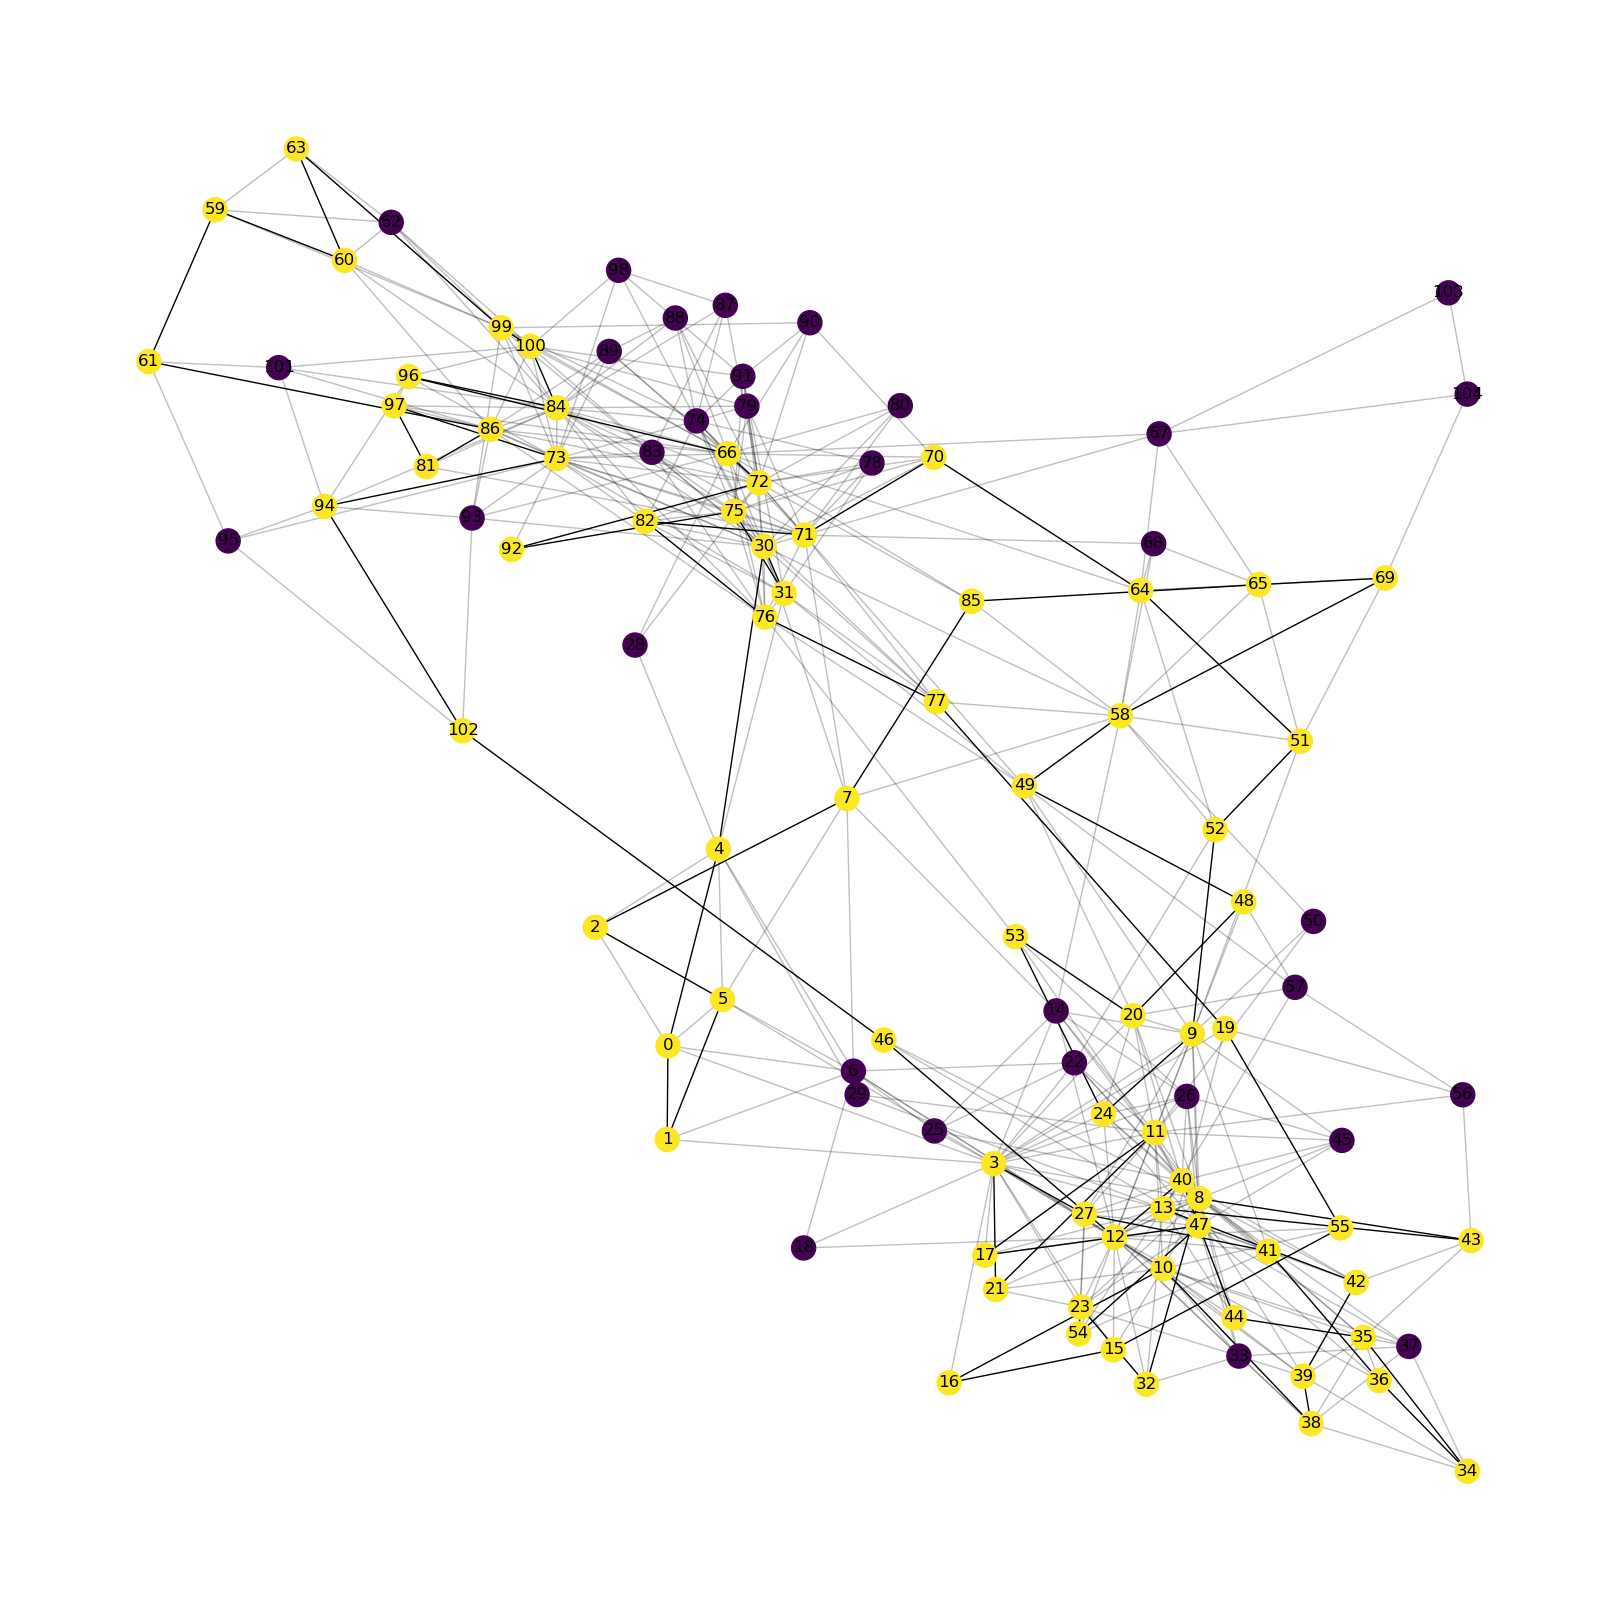

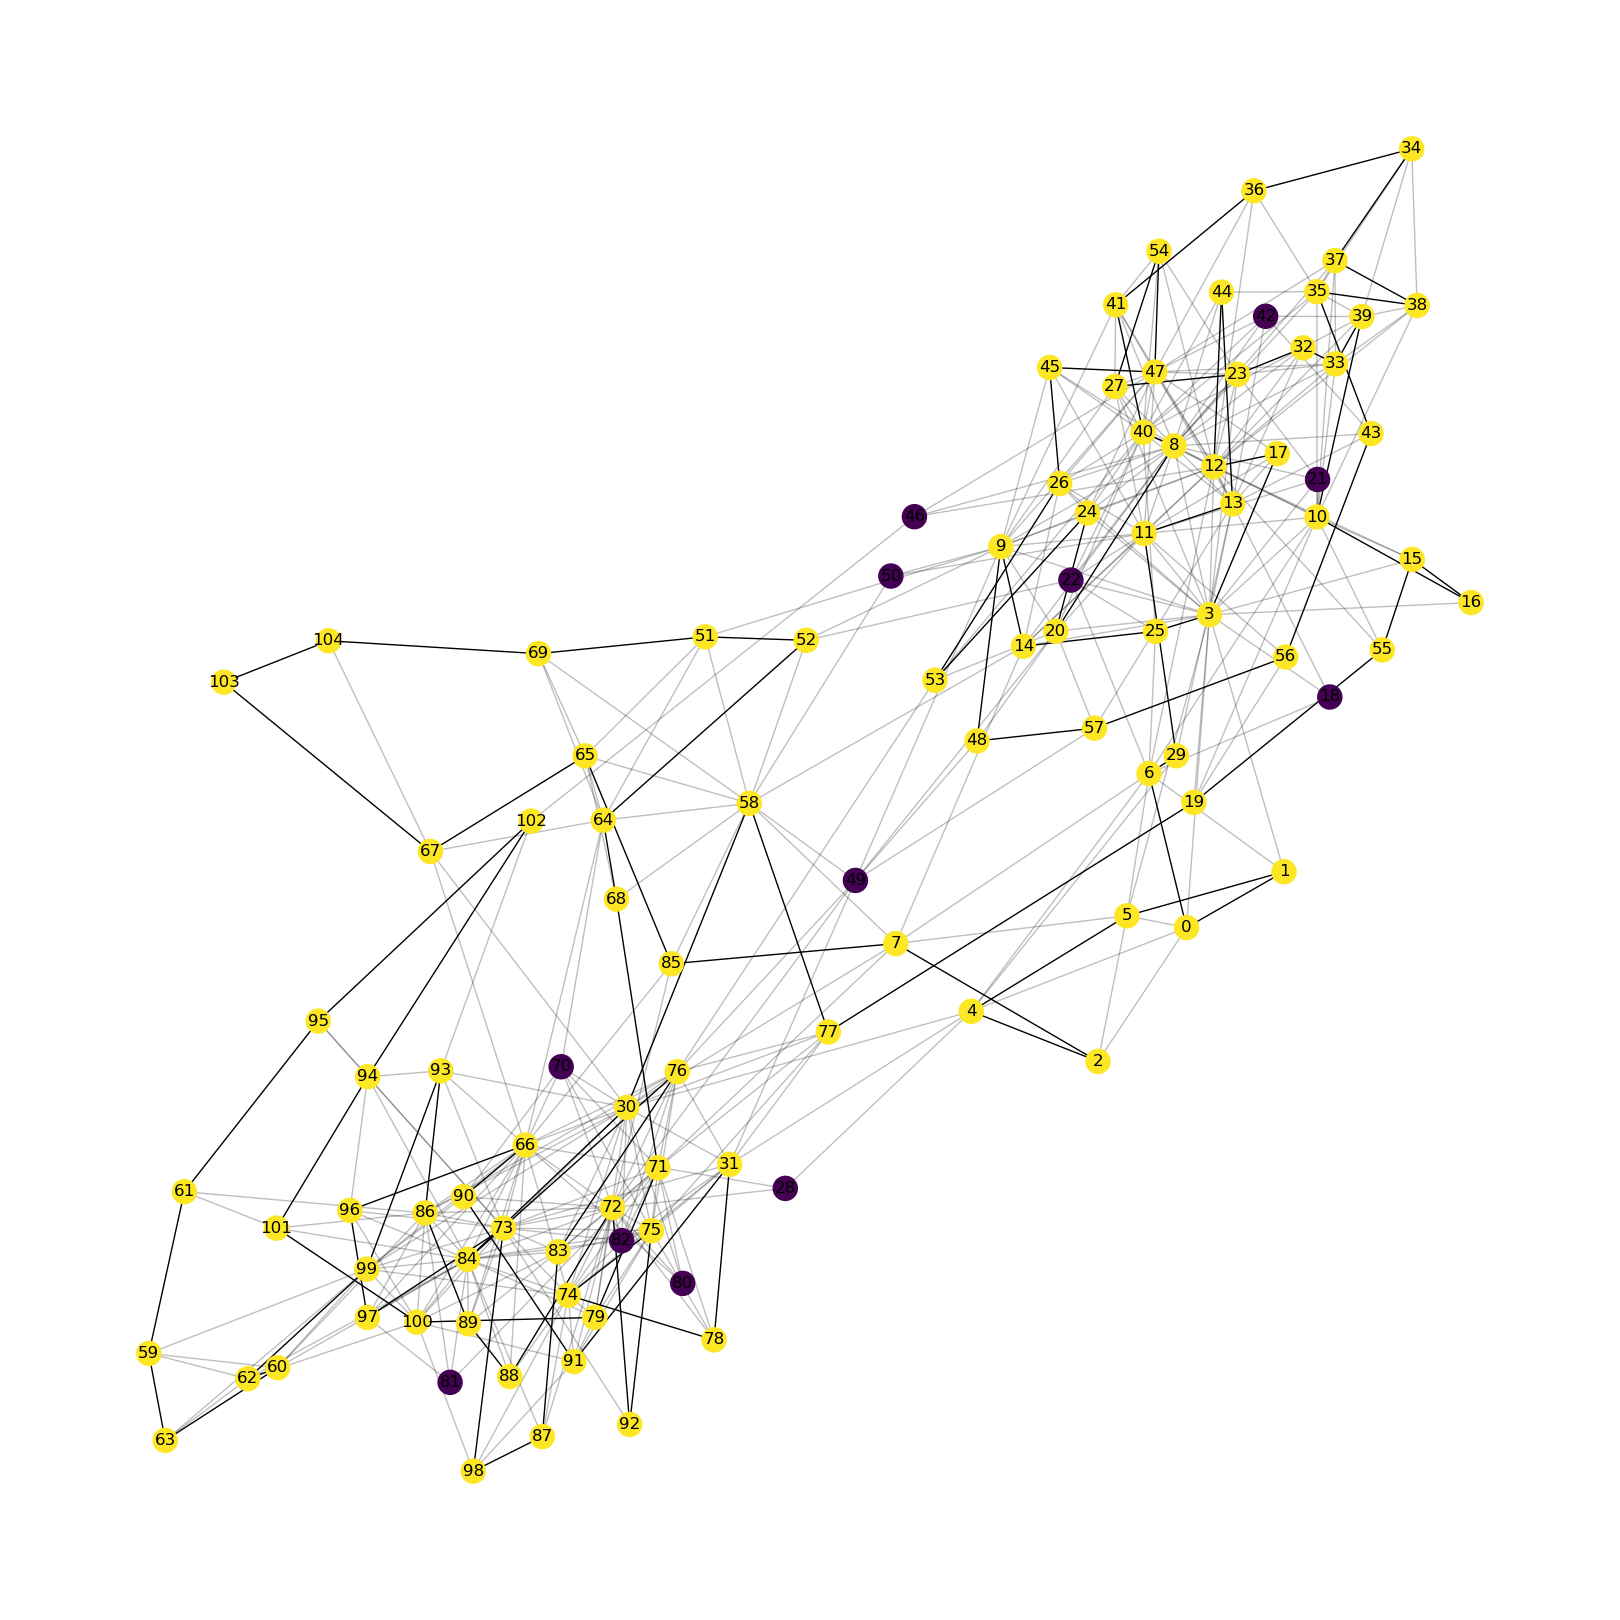

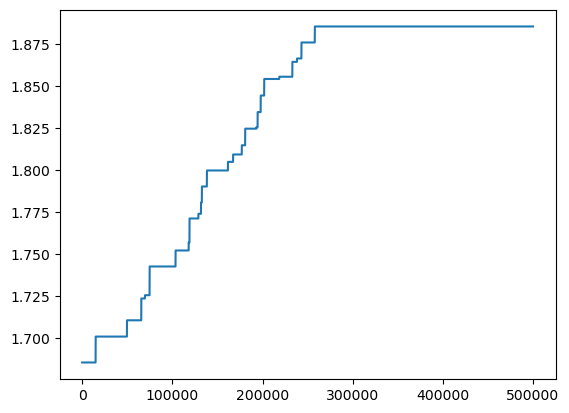

In [ ]:
@dataclasses.dataclass(frozen=True)
class TaggedCandidate:
    value: numpy.ndarray
    fitness: float

class PaperSolver:
    def __init__(self, graph: networkx.classes.Graph):
        self.source_node = 0
        self.graph = graph
    
    def __generate_candidate(self) -> numpy.ndarray:
        while True:
            candidate = numpy.full(self.graph.number_of_nodes(), -1)
            candidate_index = 0
            
            visited = numpy.zeros(self.graph.number_of_nodes())
            
            # pick random node from neighbors that's not visited
            # if there are no such negihbors, stop
            # if it picks source_node, stop
            
            current_node = self.source_node
            while True:
                neighbors = self.graph.neighbors(current_node)
                neighbors = (node for node in neighbors if visited[node] == 0)
                neighbors = list(neighbors)
                if len(neighbors) == 0:
                    break
                
                next_node = random.choice(neighbors)
                visited[next_node] = 1
                
                candidate[candidate_index] = current_node
                candidate_index += 1
                current_node = next_node
                
                if visited[self.source_node] == 1:
                    break
            
            if visited[self.source_node] == 1:
                break
        
        return candidate
    
    def __crossover(
        self,
        p1: numpy.ndarray,
        p2: numpy.ndarray,
    ) -> list[numpy.ndarray]:
        # find common nodes of p1 and p2
        # if there are none, return None
        # if there are some,
        
        n = self.graph.number_of_nodes()

        p1_node_index = numpy.full(n, -1)
        for index, node in enumerate(p1):
            if node == -1:
                break
            
            # ignore first node
            if index == 0:
                continue
            
            p1_node_index[node] = index
        
        shared_nodes = []
        for index, node in enumerate(p2):
            if node == -1:
                break
            
            if p1_node_index[node] != -1:
                shared_nodes.append((p1_node_index[node], index))
        
        if len(shared_nodes) == 0:
            return []
        
        p1_index, p2_index = random.choice(shared_nodes)
        
        c1 = numpy.concatenate([p1[:p1_index], p2[p2_index:]])
        c2 = numpy.concatenate([p2[:p2_index], p1[p1_index:]])
        
        cs = [c1, c2]
        
        def fix_c(c: numpy.ndarray) -> typing.Optional[numpy.ndarray]:
            if len(c) > n:
                if c[n] == -1:
                    c = c[:n]
                    return c
            else:
                c = numpy.concatenate([c, numpy.full(n-len(c), -1)])
                return c
            return None
        
        cs = [fix_c(c) for c in cs]
        cs = [c for c in cs if c is not None]
        
        # for c in cs:
        #     done = False
        #     for node in c:
        #         if not done:
        #             if node == -1:
        #                 done = True
        #         else:
        #             if node != -1:
        #                 print(p1_index, p2_index)
        #                 print(p1[p1_index], p2[p2_index])
        #                 print(p1, p2)
        #                 print(p1[:p1_index], p2[p2_index:])
        #                 print(p2[:p2_index], p1[p1_index:])
        #                 print(c1, c2)
        #                 print(fix_c(c1), fix_c(c2))
        #                 print("=====")
                        
        
        return cs
    
    def __fitness(self, candidate, *, debug=False):
        # optimize for:
        # - nodes being different
        # - length being same as number of nodes in graph
        
        last_node_index = len(candidate)-1
        while candidate[last_node_index] == -1:
            last_node_index -= 1
        
        if candidate[0] not in self.graph.neighbors(candidate[last_node_index]):
            return 0
        
        unique_nodes = numpy.unique(candidate)
        if unique_nodes[0] == -1:
            unique_nodes = unique_nodes[1:]
        
        unique_nodes_percentage2 = len(unique_nodes) / numpy.sum(candidate != -1)
        unique_nodes_percentage = len(unique_nodes) / len(candidate)
        
        # total_nodes_percentage = numpy.sum(candidate != -1) / len(candidate)
        
        if debug:
            print(unique_nodes_percentage)
            print(unique_nodes_percentage2)
        
        fitness = unique_nodes_percentage + unique_nodes_percentage2
        
        return fitness
    
    def __mutate(self, candidate: numpy.ndarray) -> numpy.ndarray:
        node_last_index = numpy.full(self.graph.number_of_nodes(), -1)
        possible_mutations = []
        
        for i, node in enumerate(candidate):
            if node_last_index[node] != -1:
                possible_mutations.append((node_last_index[node], i))
            node_last_index[node] = i
        
        if len(possible_mutations) == 0:
            return candidate
        
        snip_begin, snip_end = random.choice(possible_mutations)
        candidate = numpy.concatenate([candidate[:snip_begin], candidate[snip_end:]])
        candidate = numpy.concatenate([candidate, numpy.full(self.graph.number_of_nodes() - len(candidate), -1)])
        return candidate
    
    def solve(self):
        population_len = 10_000
        # generations = 20000
        generations = 500_000
        mutation_chance = 0.2
        
        best_fitness_hist = []
        
        population = [
            self.__generate_candidate()
            for _ in range(population_len)
        ]
        
        population = [
            TaggedCandidate(
                candidate,
                self.__fitness(candidate),
            )
            for candidate in population
        ]
        
        population = sortedcontainers.SortedList(
            population,
            lambda candidate: candidate.fitness,
        )
    
        widget_fitness = ipywidgets.Label()
        widget_progress = ipywidgets.IntProgress(min=0, max=generations-1)
        widget = ipywidgets.VBox([
            ipywidgets.Label(value="evolving..."),
            ipywidgets.HBox([
                ipywidgets.Label(value="fitness = "),
                widget_fitness,
            ]),
            widget_progress,
        ])

        display(widget)
        
        plt.figure(figsize=(16,16))
        draw_candidate(self.graph, population[-1].value)
        
        for generation_index in range(generations):
            ps = random.choices(population, k=2)
            p1, p2 = ps[0], ps[1]
            
            cs = self.__crossover(p1.value, p2.value)
            cs = [
                self.__mutate(candidate) if random.random() < mutation_chance else candidate
                for candidate in cs
            ]
            cs = [
                TaggedCandidate(
                    candidate,
                    self.__fitness(candidate),
                )
                for candidate in cs
            ]
            
            for c in cs:
                if c.fitness > population[0].fitness:
                    population.pop(0)
                    population.add(c)
            
            if generation_index % 1000 == 0:
                widget_progress.value = generation_index
                widget_fitness.value = str(population[-1].fitness)
            best_fitness_hist.append(population[-1].fitness)
        
        best_candidate = population[-1]
        
        self.__fitness(best_candidate.value, debug=True)
        print(best_candidate.value)
        
        plt.figure(figsize=(16,16))
        draw_candidate(self.graph, best_candidate.value)
        
        plt.figure()
        plt.plot(best_fitness_hist)

data = datas['community_krebs']
solver = Solver(data.graph)
solver.solve()

#### Permutations

In [54]:
# set results to empty dict, only if it doesn't already exist
try:
    results
except NameError:
    results = {}

In [121]:
@dataclasses.dataclass(frozen=True)
class TaggedCandidate:
    value: numpy.ndarray
    fitness: float
    
@dataclasses.dataclass(kw_only=True)
class Result:
    value: numpy.ndarray
    extra_values: list[numpy.ndarray]
    best_fitness_hist: numpy.ndarray
    final_fitness_distribution: numpy.ndarray

class FitnessFunction(enum.Enum):
    EdgePresence = enum.auto()
    EdgeWeight = enum.auto()
    DontVisitAll = enum.auto()

@dataclasses.dataclass(kw_only=True)
class SolverParameters:
    population_len: int
    generations_count: int
    mutation_chance: float
    fitness_function: FitnessFunction
    
class PermutationSolver:
    def __init__(
        self,
        graph: networkx.classes.Graph,
        parameters: SolverParameters
    ):
        self.graph = graph
        self.__parameters = parameters
        
        self.__m1 = numpy.zeros(self.graph.number_of_nodes())
        self.__m2 = numpy.zeros(self.graph.number_of_nodes())
    
    def __generate_candidate(self) -> numpy.ndarray:
        candidate = numpy.array(range(self.graph.number_of_nodes()))
        rng = numpy.random.default_rng()
        rng.shuffle(candidate)
        return candidate
    
    def __crossover(
        self,
        p1: numpy.ndarray,
        p2: numpy.ndarray,
    ) -> list[numpy.ndarray]:
        cross_start = random.randint(0, self.graph.number_of_nodes()-2)
        cross_end = random.randint(cross_start+1, self.graph.number_of_nodes()-1)
        
        c1 = numpy.copy(p1)
        c2 = numpy.copy(p2)
        
        numpy.copyto(c1[cross_start:cross_end+1], p2[cross_start:cross_end+1])
        numpy.copyto(c2[cross_start:cross_end+1], p1[cross_start:cross_end+1])
        
        self.__m1.fill(-1)
        self.__m2.fill(-1)
        
        for i in range(cross_start, cross_end+1):
            self.__m1[c1[i]] = c2[i]
            self.__m2[c2[i]] = c1[i]
        
        for i in itertools.chain(range(0, cross_start), range(cross_end+1, self.graph.number_of_nodes())):
            while self.__m1[c1[i]] != -1:
                c1[i] = self.__m1[c1[i]]
            while self.__m2[c2[i]] != -1:
                c2[i] = self.__m2[c2[i]]
        
        return [c1, c2]
    
    def __fitness(self, candidate: numpy.ndarray) -> float:
        if self.__parameters.fitness_function == FitnessFunction.EdgePresence:
            edges = zip(
                candidate,
                itertools.chain(itertools.islice(candidate, 1, None), [candidate[0]]),
            )

            fitness = 0
            node_first = None
            node_last = None
            for node_from, node_to in edges:
                if self.graph.has_edge(node_from, node_to):
                    fitness += 1
            fitness /= self.graph.number_of_nodes()+1
        elif self.__parameters.fitness_function == FitnessFunction.EdgeWeight:
            edges = zip(
                candidate,
                itertools.chain(itertools.islice(candidate, 1, None), [candidate[0]]),
            )

            fitness = 0
            for node_from, node_to in edges:
                weight = self.graph.get_weight(node_from, node_to)
                fitness -= weight
        elif self.__parameters.fitness_function == FitnessFunction.DontVisitAll:
            edges = zip(
                itertools.chain([0], candidate),
                candidate,
            )
            
            valid = True
            length_until_source = 0
            
            for node_from, node_to in edges:
                if not self.graph.has_edge(node_from, node_to):
                    valid = False
                    break
                length_until_source += 1
                
                if node_to == 0:
                    break
            
            if not valid or length_until_source <= 2:
                fitness = -999999
            else:
                fitness = -length_until_source
        
        return fitness
    
    def __mutate(self, candidate: numpy.ndarray) -> numpy.ndarray:
        swap_1 = random.randint(0, self.graph.number_of_nodes()-1)
        swap_2 = random.randint(0, self.graph.number_of_nodes()-1)
        
        candidate[swap_1], candidate[swap_2] = candidate[swap_2], candidate[swap_1]
        
        return candidate
    
    def solve(self) -> Result:
        best_fitness_hist = numpy.zeros(self.__parameters.generations_count)
    
        # generate population
        widget_progress_population = ipywidgets.IntProgress(min=0, max=self.__parameters.population_len-1)
        widget = ipywidgets.VBox([
            ipywidgets.Label(value="generating population..."),
            widget_progress_population,
        ])
        display(widget)
        
        population = sortedcontainers.SortedList(
            [], lambda candidate: candidate.fitness,
        )
        
        prev_status_update_index = None
        for candidate_index in range(self.__parameters.population_len):
            candidate = self.__generate_candidate()
            candidate = TaggedCandidate(candidate, self.__fitness(candidate))
            population.add(candidate)
            
            # status update
            status_update_index = int((candidate_index / (self.__parameters.population_len-1)) * 250)
            if prev_status_update_index is None or status_update_index > prev_status_update_index:
                prev_status_update_index = status_update_index
                widget_progress_population.value = candidate_index
        
        # evolve
        widget_fitness = ipywidgets.Label()
        widget_estimated_time_left = ipywidgets.Label()
        widget_progress_generations = ipywidgets.IntProgress(min=0, max=self.__parameters.generations_count-1)
        widget = ipywidgets.VBox([
            ipywidgets.Label(value="evolving..."),
            ipywidgets.HBox([
                ipywidgets.Label(value="fitness = "),
                widget_fitness,
            ]),
            ipywidgets.HBox([
                ipywidgets.Label(value="estimated time left = "),
                widget_estimated_time_left,
            ]),
            widget_progress_generations,
        ])
        display(widget)
        
        prev_status_update_index = None
        for generation_index in range(self.__parameters.generations_count):
            status_update_index = int((generation_index / (self.__parameters.generations_count-1)) * 250)
            do_status_update = prev_status_update_index is None or status_update_index > prev_status_update_index
            
            if do_status_update:
                generation_begin = time.time()
            
            # crossover
            ps = random.choices(population, k=2)
            p1, p2 = ps[0], ps[1]
            
            cs = self.__crossover(p1.value, p2.value)
            
            # mutation
            cs = [
                self.__mutate(c) if random.random() < self.__parameters.mutation_chance else c
                for c in cs
            ]
            
            cs = [TaggedCandidate(c, self.__fitness(c)) for c in cs]
            
            for c in cs:
                if c.fitness > population[0].fitness:
                    population.pop(0)
                    population.add(c)
            
            if do_status_update:
                generation_end = time.time()
            
            # status update
            if do_status_update:
                prev_status_update_index = status_update_index
                widget_progress_generations.value = generation_index
                widget_fitness.value = str(population[-1].fitness)
                generation_time = generation_end-generation_begin
                widget_estimated_time_left.value = str(
                      generation_time
                    * (self.__parameters.generations_count-1 - generation_index)
                )
            
            best_fitness_hist[generation_index] = population[-1].fitness
        
        best_candidate = population[-1]
        extra_values = []
        for i in range(2, len(population)+1):
            if math.isclose(best_candidate.fitness, population[-i].fitness):
                extra_values.append(population[-i].value)
            else:
                break
        final_fitness_distribution = numpy.array([candidate.fitness for candidate in population])
        
        return Result(
            value=best_candidate.value,
            extra_values=extra_values,
            best_fitness_hist=best_fitness_hist,
            final_fitness_distribution=final_fitness_distribution,
        )


def solve(
    name: str,
    parameters: SolverParameters,
    *,
    show_graph: bool = False,
    weird_graph: bool = False,
):
    data = datas[name]
    
    widget = ipywidgets.VBox([
        ipywidgets.Label(value=name),
        ipywidgets.Label(value=f"nodes_count = {data.graph.number_of_nodes()}")
    ])
    display(widget)
    
    if show_graph and data.graph.get_networkx_graph() is not None:
        plt.figure(figsize=(16,16))
        plt.title(name)
        networkx.draw(data.graph.get_networkx_graph())
    
    solver = PermutationSolver(data.graph, parameters)
    result = solver.solve()
    results[name] = result
    
    print(result.value)
    print("extra_answer_count = ", len(result.extra_values))
    
    if show_graph and data.graph.get_networkx_graph() is not None:
        if weird_graph:
            value = result.value.copy()
            i = 0
            while value[i] != 0:
                i += 1
            
            value = value[:i+1]
        else:
            value = result.value
        
        plt.figure(figsize=(16,16))
        plt.title(name)
        draw_candidate(data.graph.get_networkx_graph(), value)
        
    plt.figure()
    plt.title(name)
    plt.plot(result.best_fitness_hist)
    
    plt.figure()
    plt.title(name)
    plt.hist(result.final_fitness_distribution, bins=100)

##### Cerinta principala

[   369  22214 109668 ...  94309   9230 101743]
extra_answer_count =  0


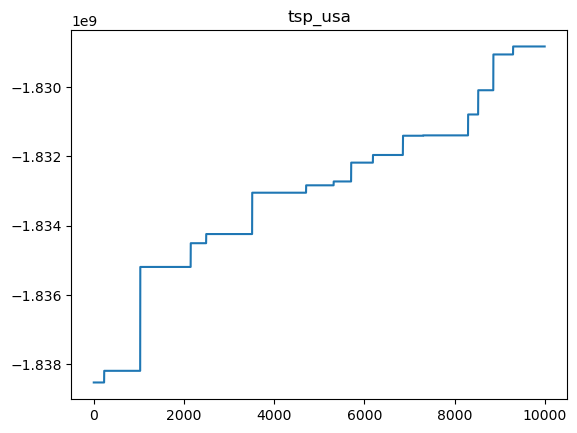

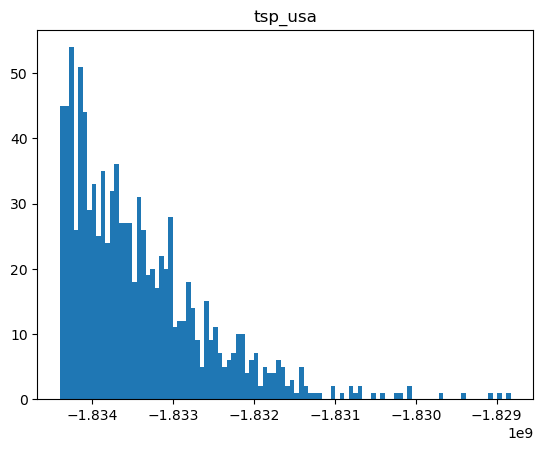

In [81]:
solve(
    "tsp_usa",
    SolverParameters(
        # population_len=10_000,
        # generations_count=2_000_000,
        fitness_function=FitnessFunction.EdgeWeight,
        population_len=1_000,
        generations_count=10_000,
        mutation_chance=0.20,
    ),
)

In [98]:
solve(
    "ungraph",
    SolverParameters(
        # population_len=10_000,
        # generations_count=2_000_000,
        fitness_function=FitnessFunction.EdgePresence,
        population_len=100,
        generations_count=100,
        mutation_chance=0.20,
    ),
)

KeyboardInterrupt: 

[ 67  46  49  48  92  15  47   2 100 102  72  56  27  65  20  21 108  22
  77  51  68   7  82  39 106   6  32  13  64  63  59  58   3  40  81  98
   4  69  88 110  24  50  36  12  85  14  99  54  38  16   9 104  41 105
  33 103  45 109  30  94  79  80  37  78  28  90   8 111  23  93  91  29
 101  18  42  26  34  31  55  89  25   1   0  35  19  44 112  97  73 114
  83  71  60  10  74   5  11  66  76  70  43  61  62  95 113  17  96  87
  86  57  75 107  84  52  53]
extra_answer_count =  9999


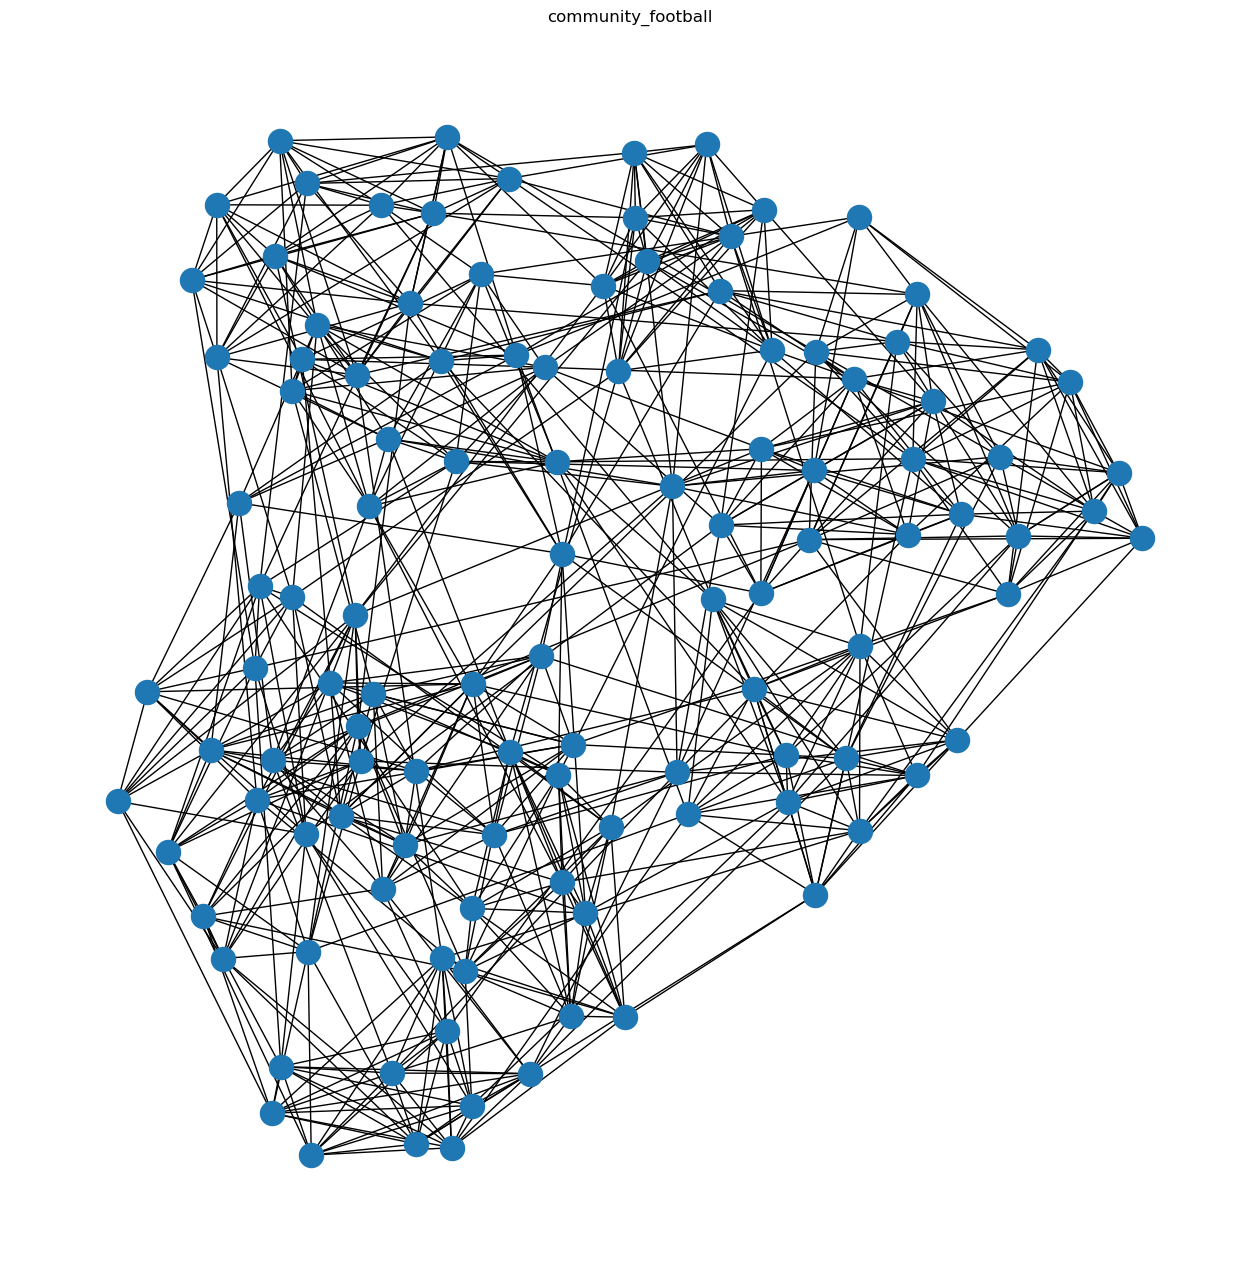

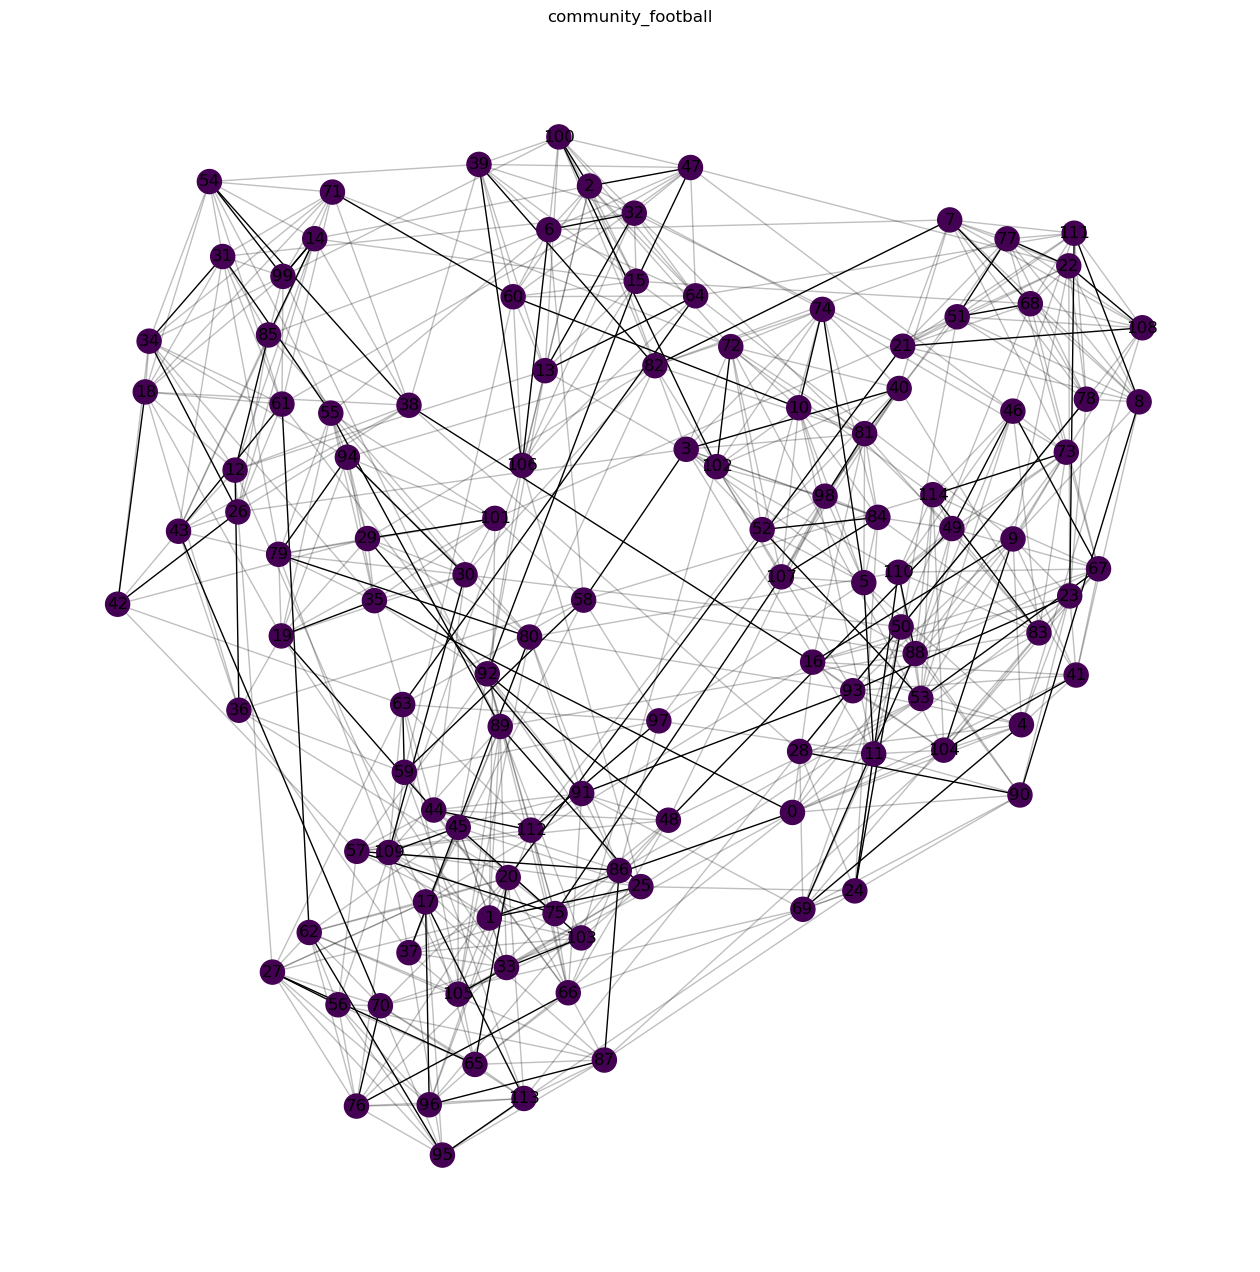

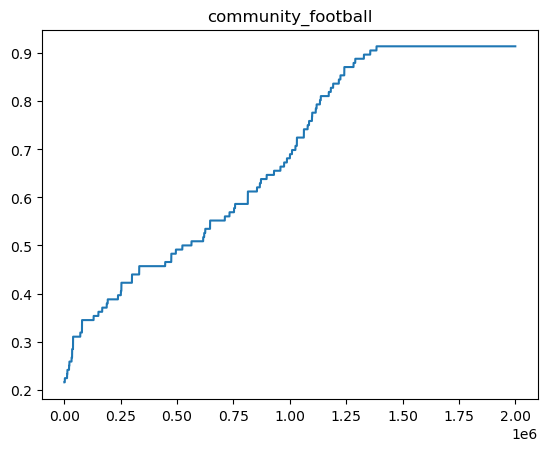

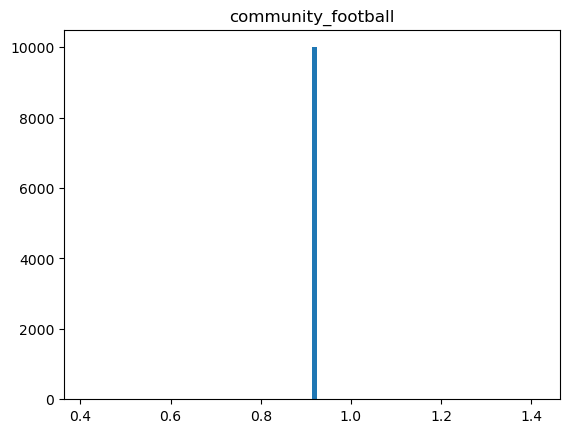

In [95]:
solve(
    "community_football",
    SolverParameters(
        fitness_function=FitnessFunction.EdgePresence,
        population_len=10_000,
        generations_count=2_000_000,
        mutation_chance=0.20,
    ),
    show_graph=True,
)

KeyboardInterrupt: 

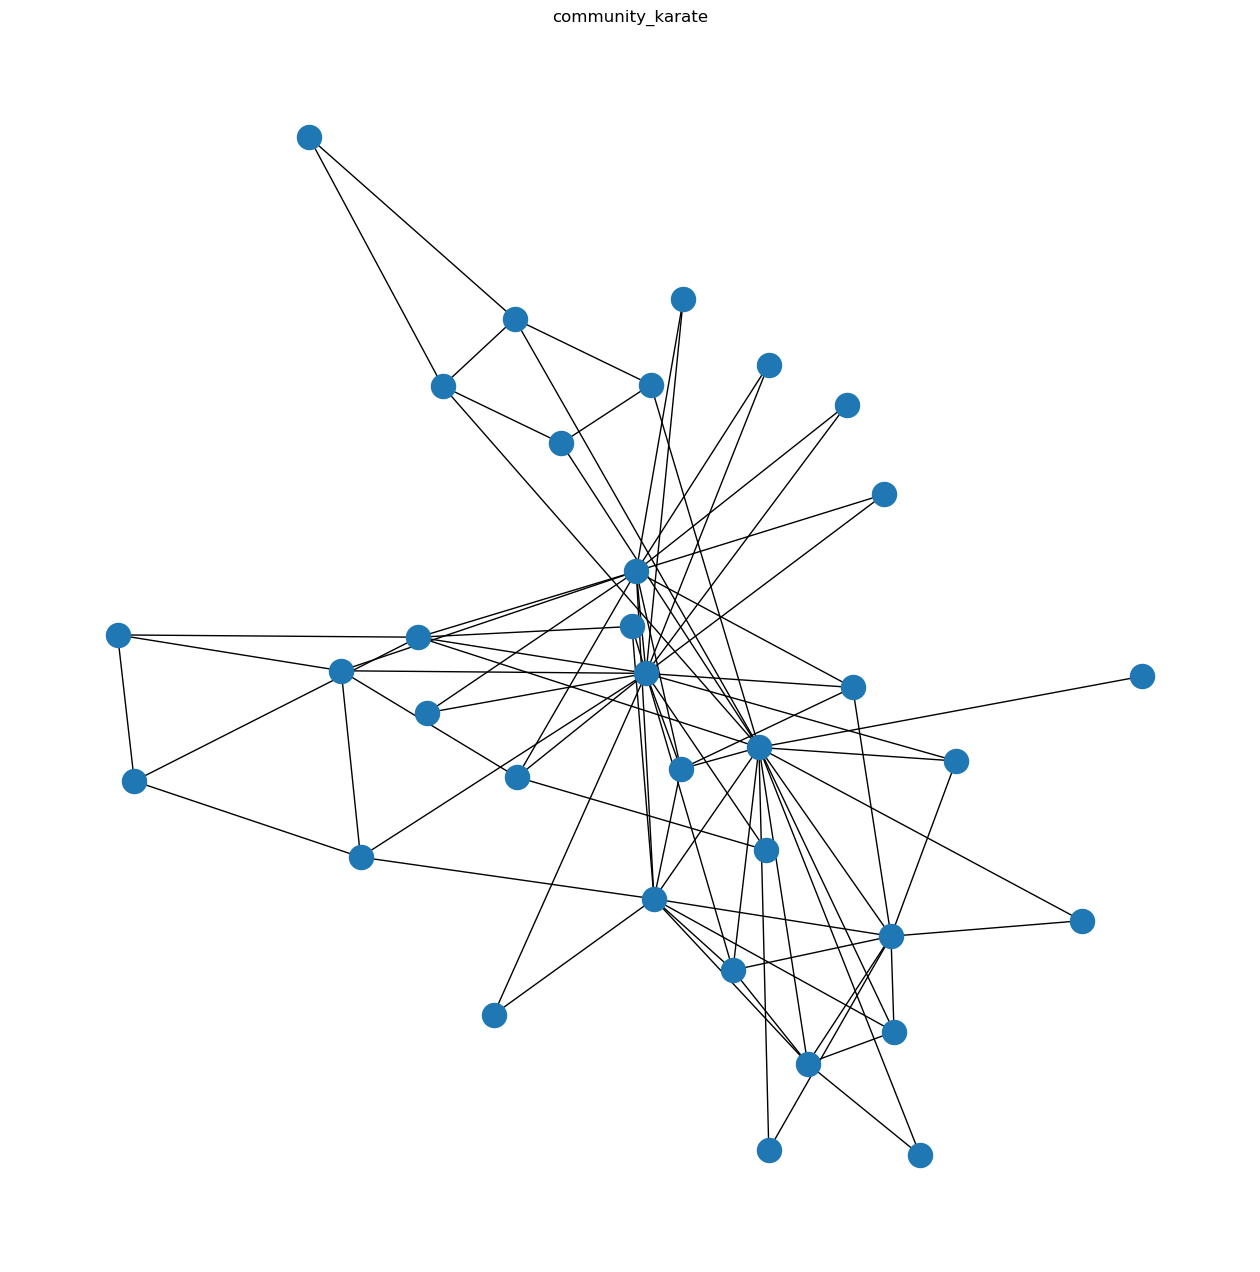

In [120]:
solve(
    "community_karate",
    SolverParameters(
        fitness_function=FitnessFunction.EdgePresence,
        population_len=10_000,
        generations_count=1_500_000,
        mutation_chance=0.20,
    ),
    show_graph=True,
)

In [119]:
result = results["community_karate"]
solutions = dict()
for candidate in result.extra_values:
    solutions[str(candidate)] = candidate
# print(list(solutions.values()))

##### Cerinta optionala 2

[  3   5   0  51  59  47  37  76  25  71   9  89  70  43  39  49  80  90
  86   1  87  78  46 104  77  17  23  96  26  10  42  29  82  22  68  74
  45  97  62  20  11  50  31  44  21 102  63  35  92  38   7  19  88  64
   2   6  13  36  79  41  84  32  75  16  28  40  30  61  12  54  67  85
  95  60   4  55  72  65  15  58  18  24  83 100  94   8  33  91  27  81
  53  66 101  57  48  56 103  99  34  14  52  93  73  98  69]
extra_answer_count =  9999


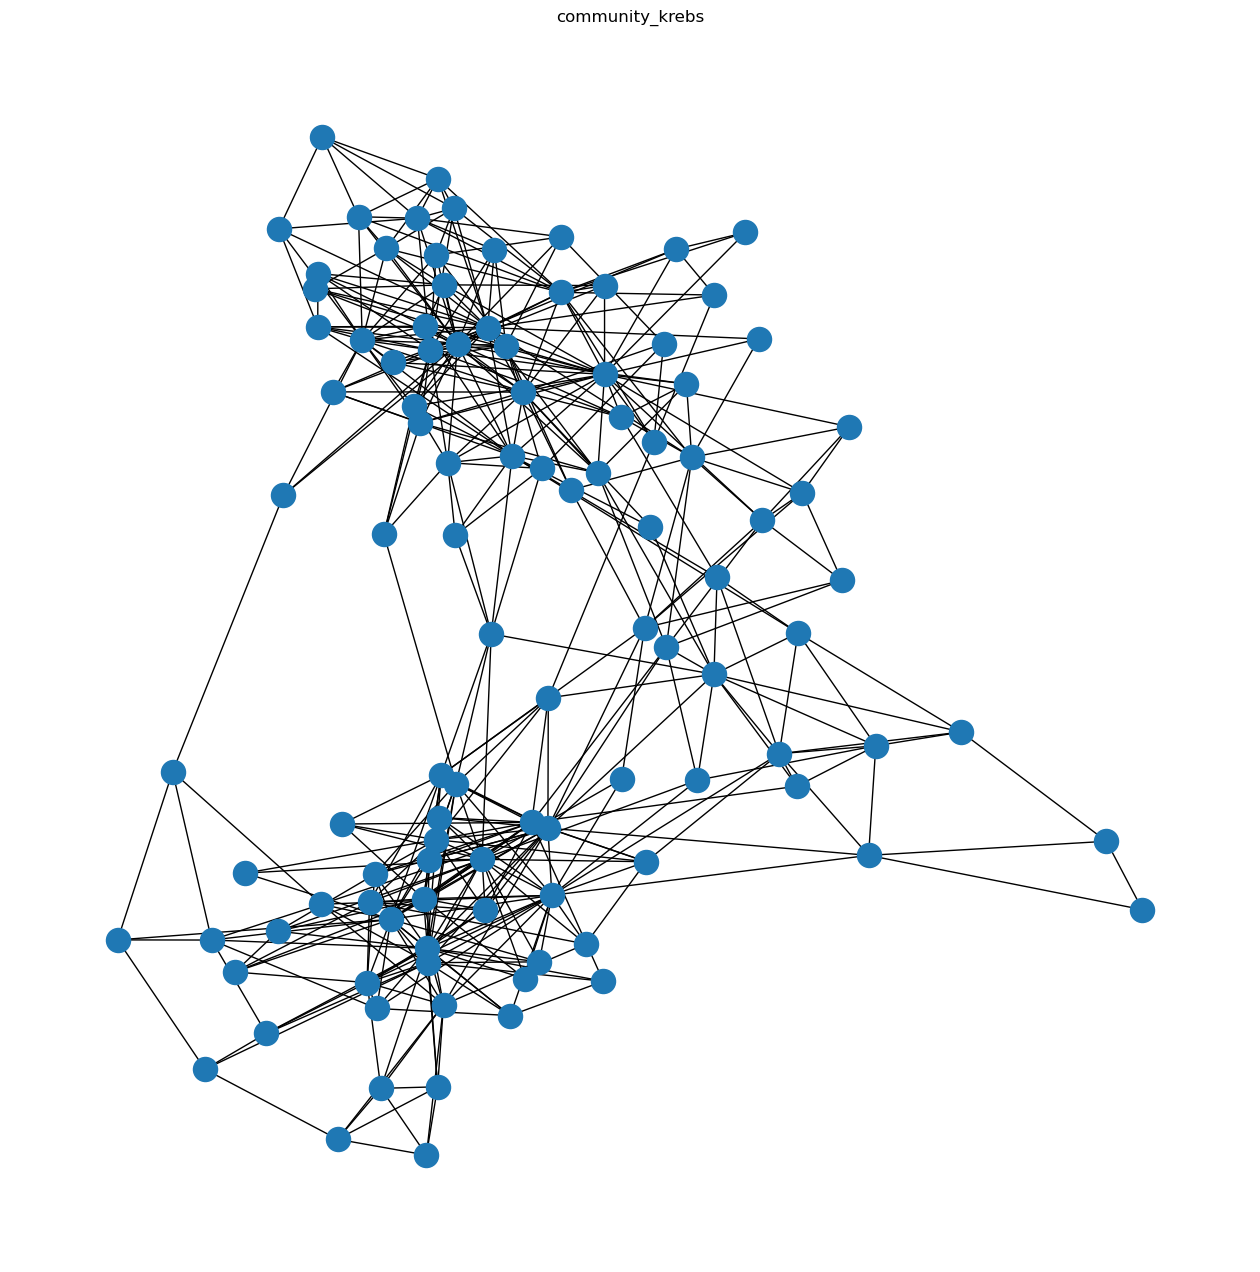

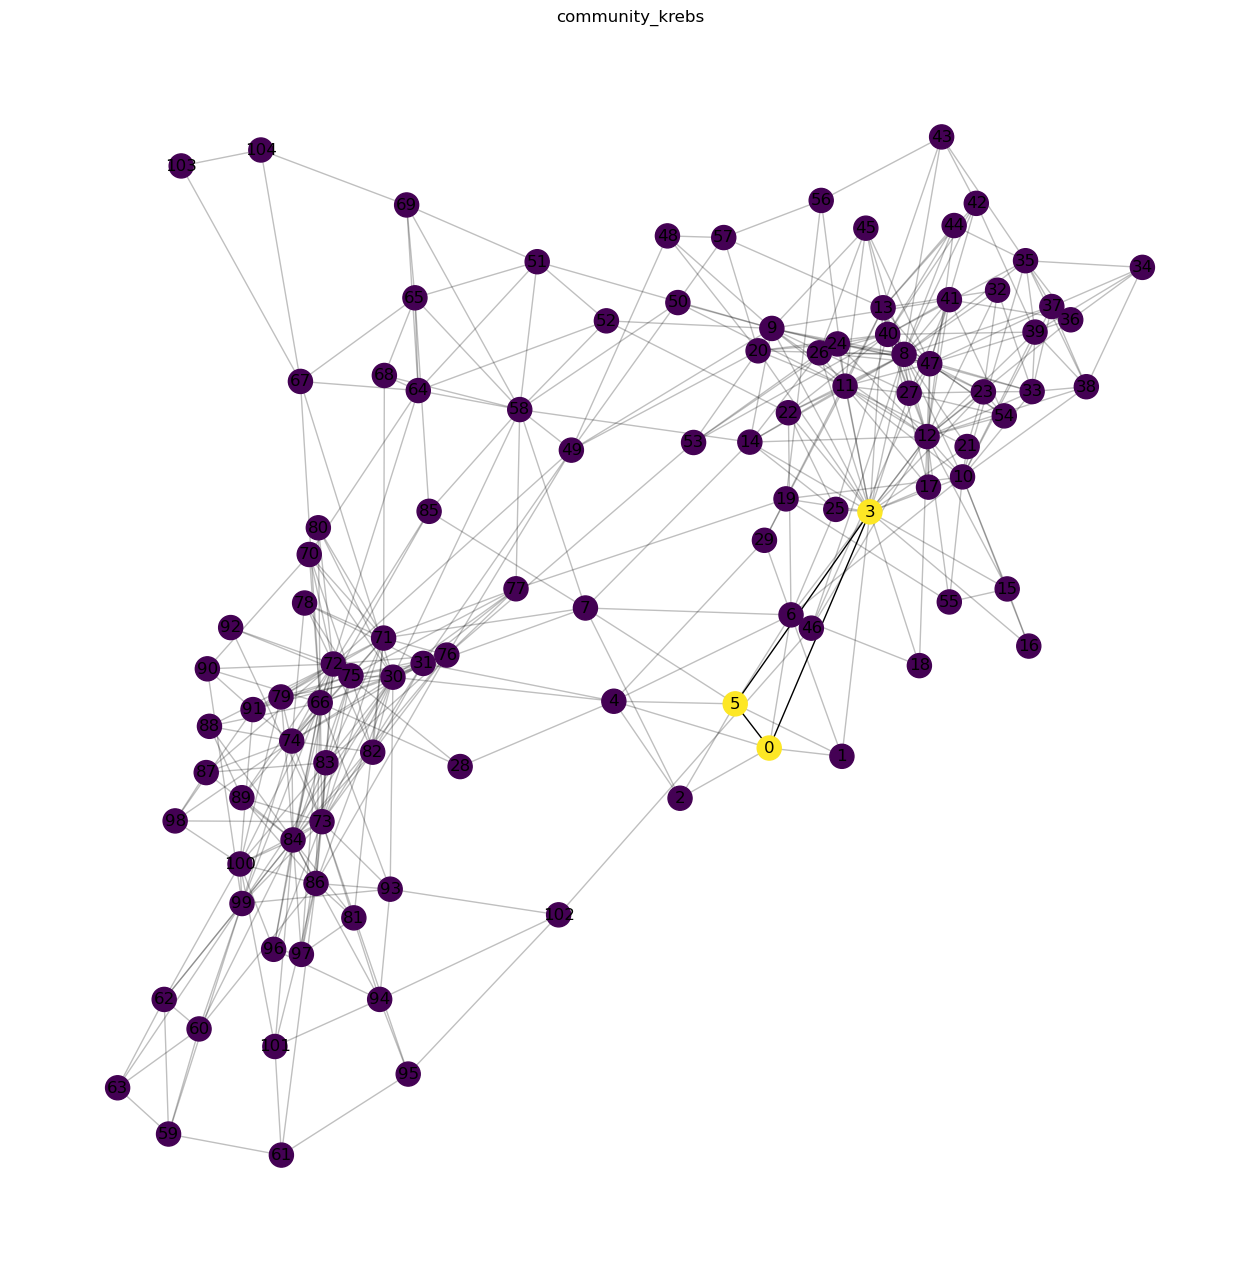

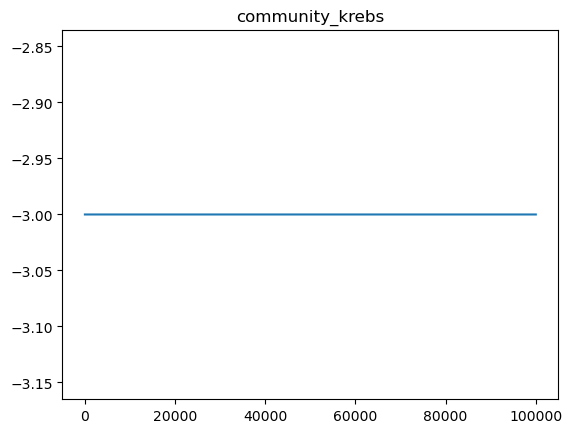

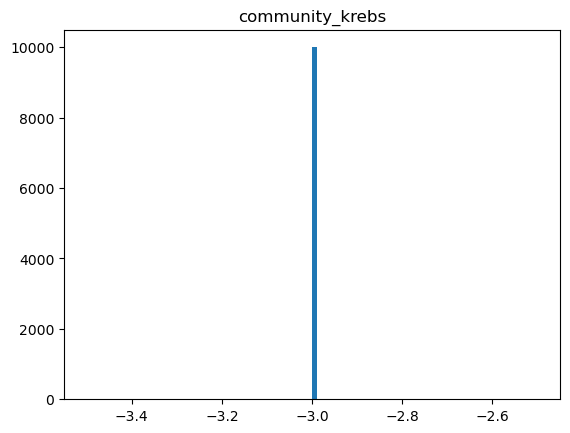

In [125]:
solve(
    "community_krebs",
    SolverParameters(
        fitness_function=FitnessFunction.DontVisitAll,
        population_len=10_000,
        generations_count=100_000,
        mutation_chance=0.20,
    ),
    show_graph=True,
    weird_graph=True,
)

[ 6  5  0  7  3  9 24 13 29  1 25 26 30 19 33  2 27  8 32  4 20 23 14 12
 18 16 15 10 21 22 31 28 17 11]
extra_answer_count =  9999


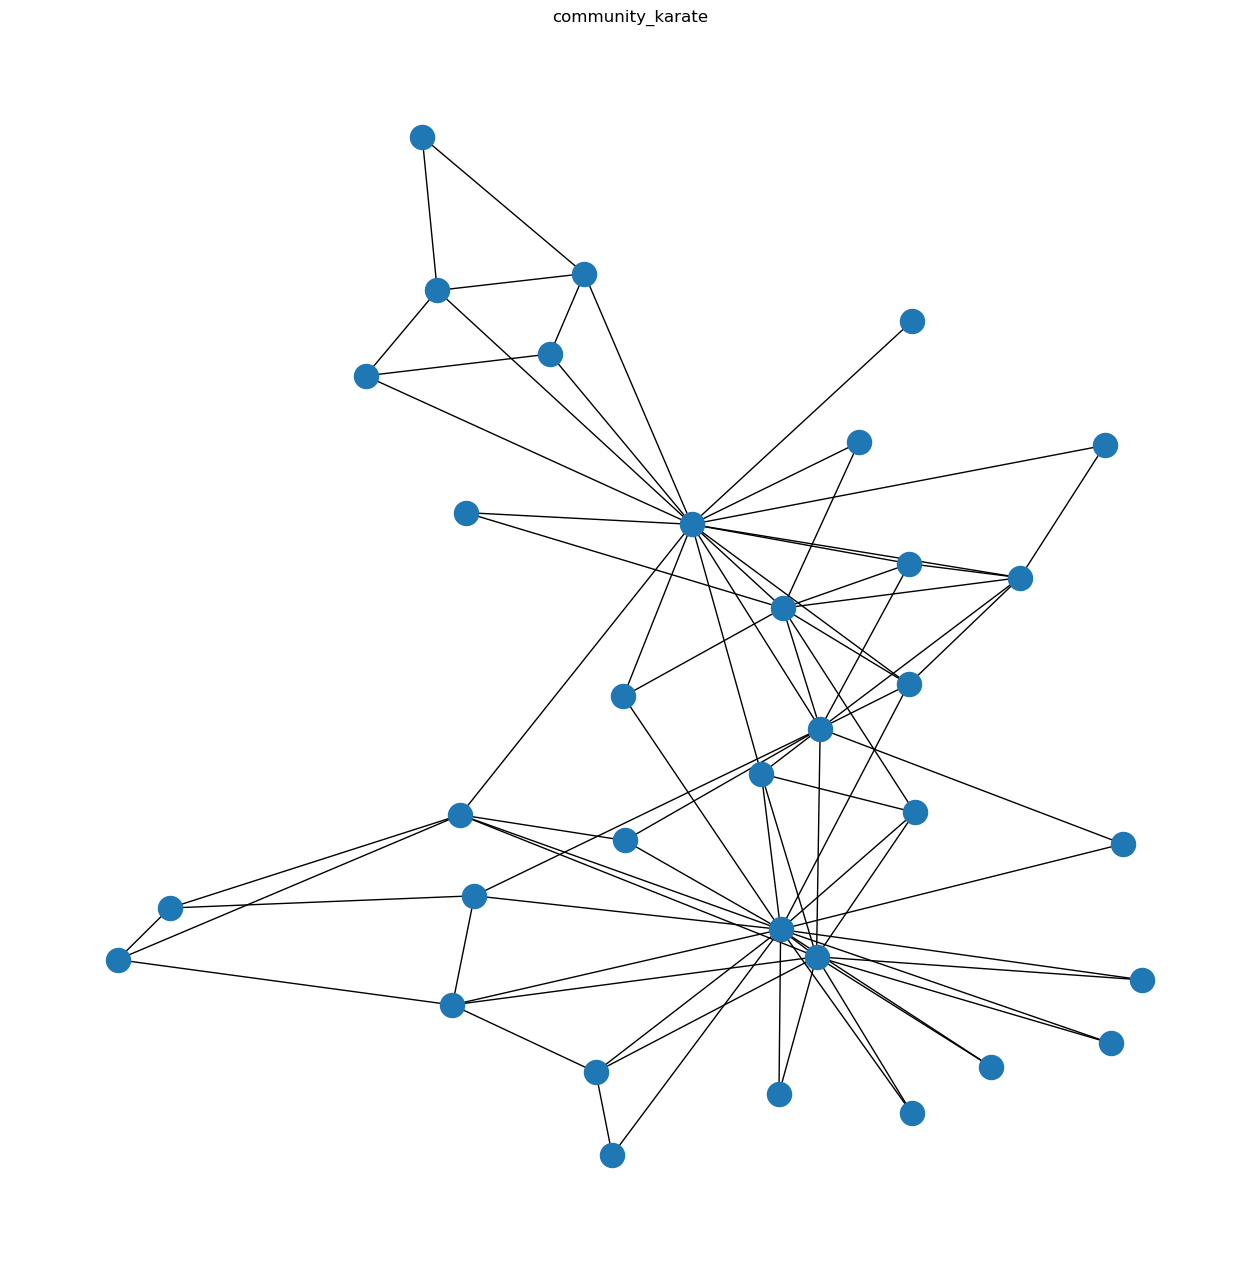

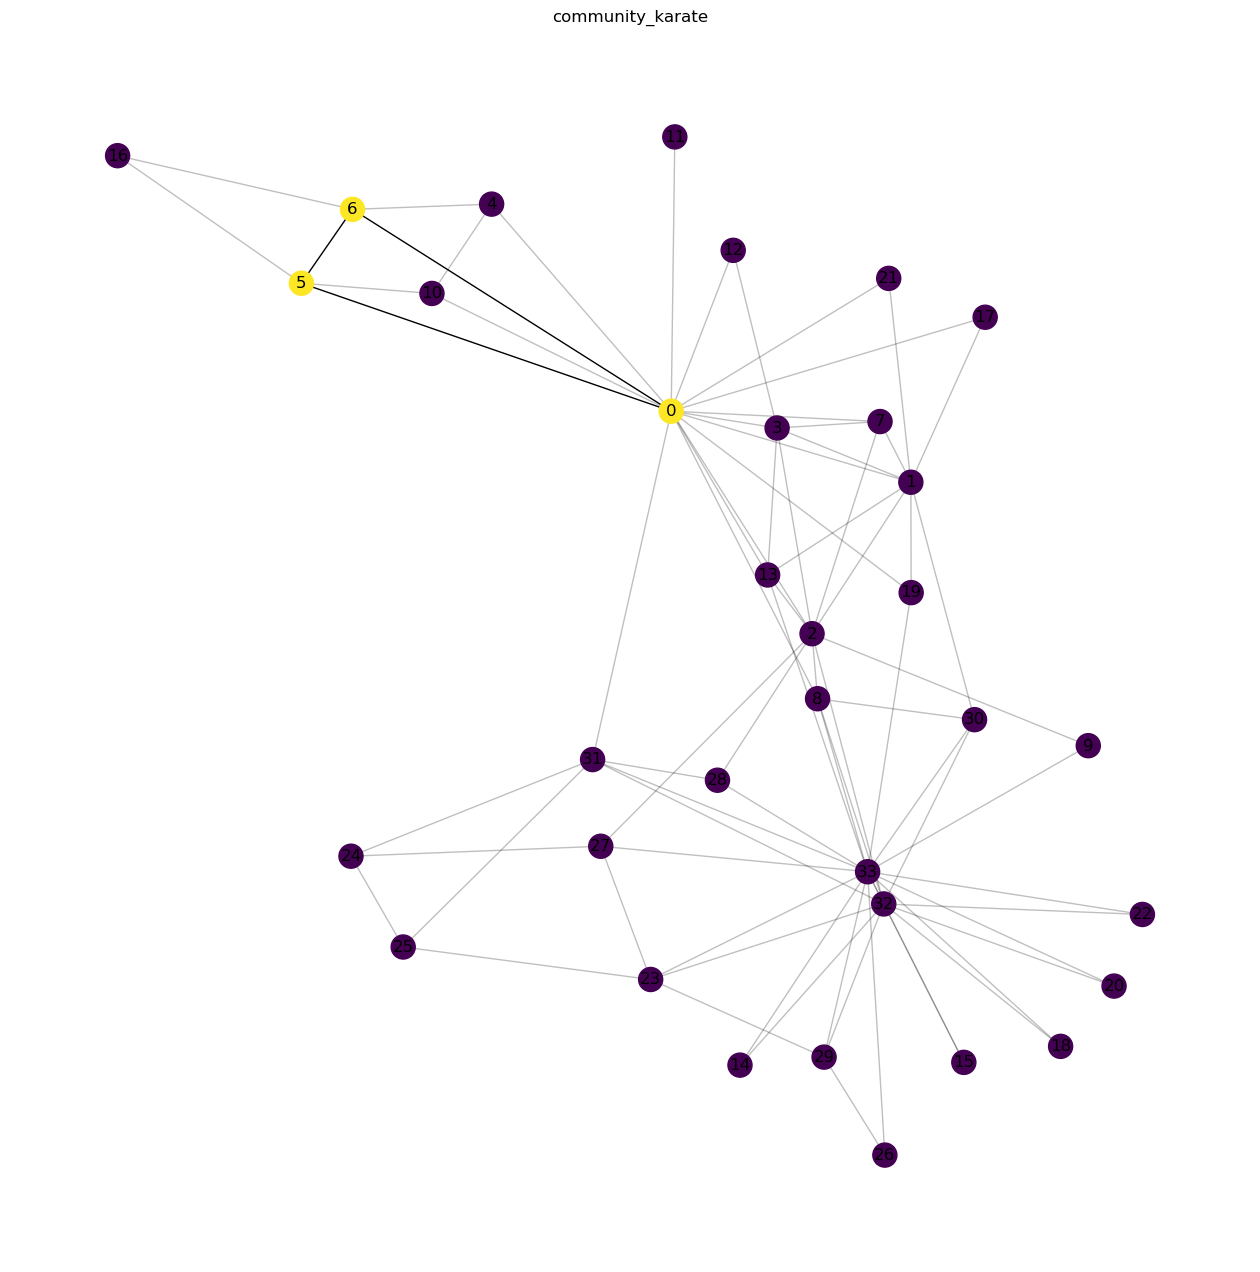

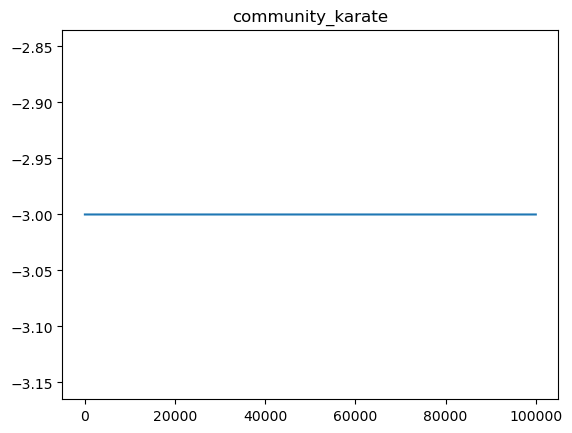

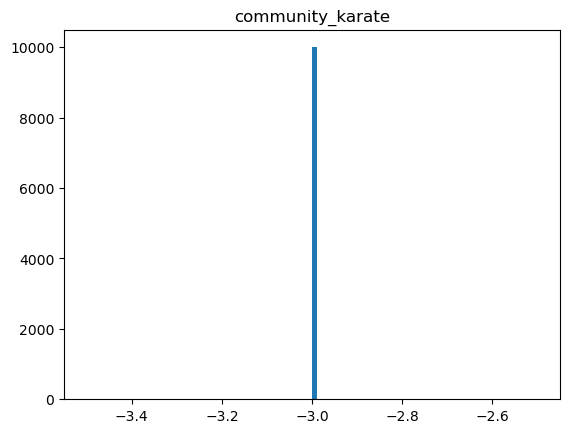

In [126]:
solve(
    "community_karate",
    SolverParameters(
        fitness_function=FitnessFunction.DontVisitAll,
        population_len=10_000,
        generations_count=100_000,
        mutation_chance=0.20,
    ),
    show_graph=True,
    weird_graph=True,
)

[  9  23   0  68 113  40  52 106   3 110  91  64  93  28  44 114  49  51
  39  70  54  74  69 108  96  61  34  35  32   8   7   2  73 112  15  21
  25  62  55 104  14 105  88  53  77  57  58 103  13  42  41  89  33  99
  78 102  30  83  90  97  87  24  38  94  84  95  46 100  60  86  19  66
  81   4  82 101  47  59 109  43  65   1  48  16  12  80  22  76   6  17
  20  27  71  18  79  10  75   5  11 107 111  98  45  85  67  50  92  72
  63  26  56  36  29  31  37]
extra_answer_count =  534


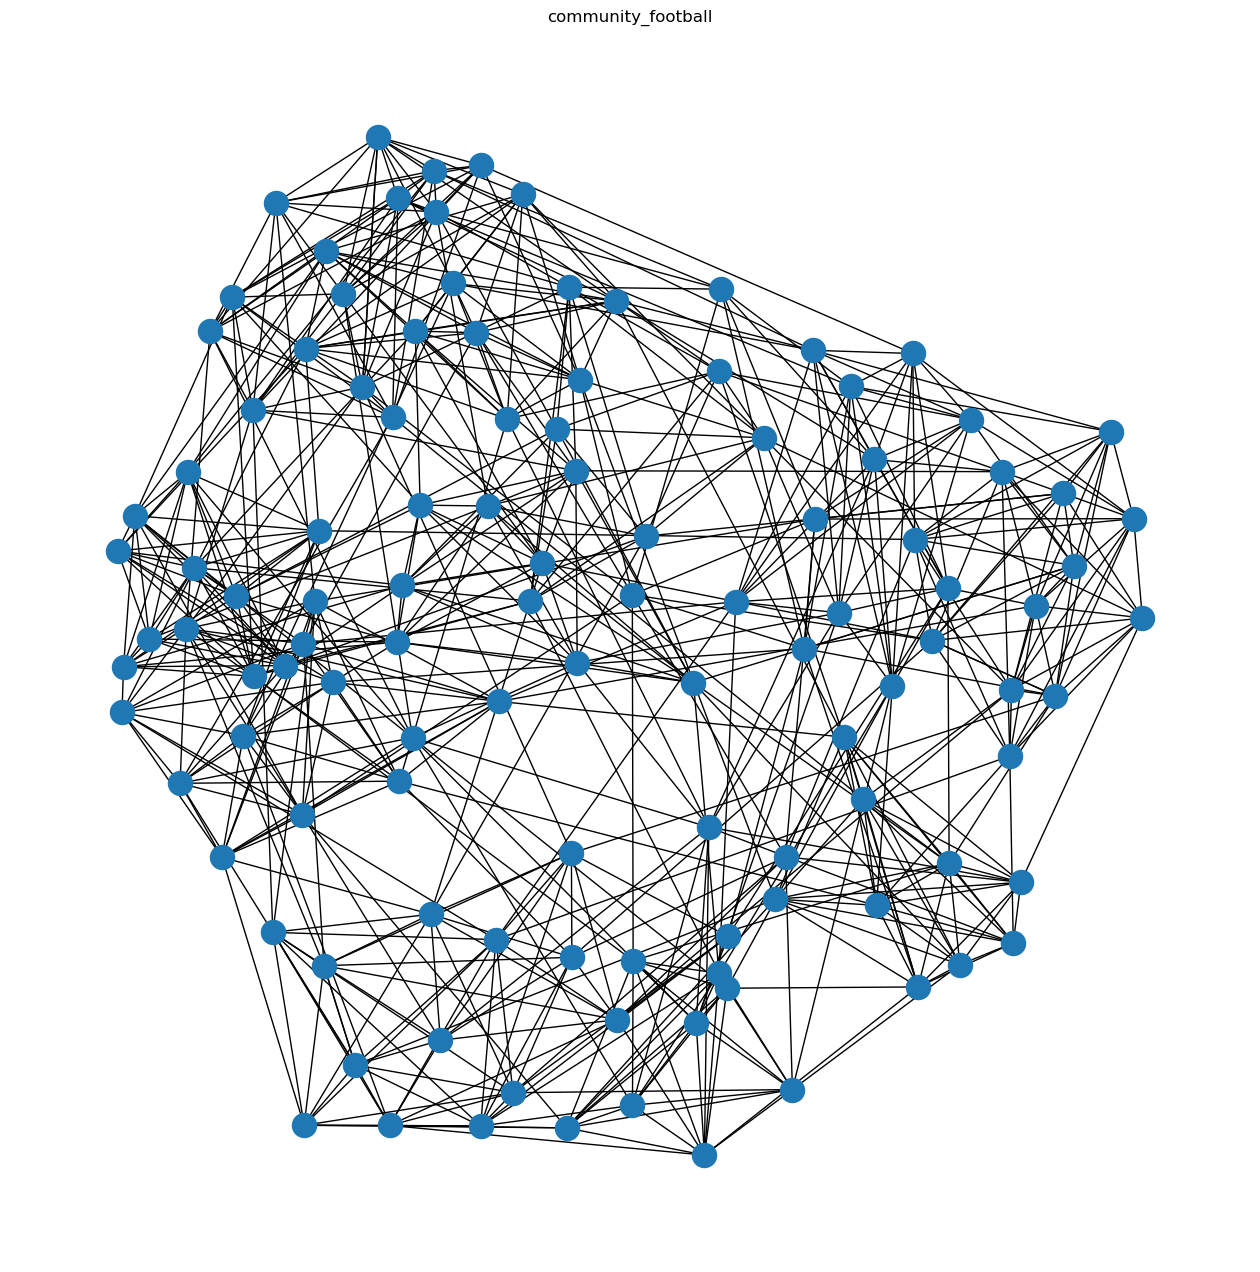

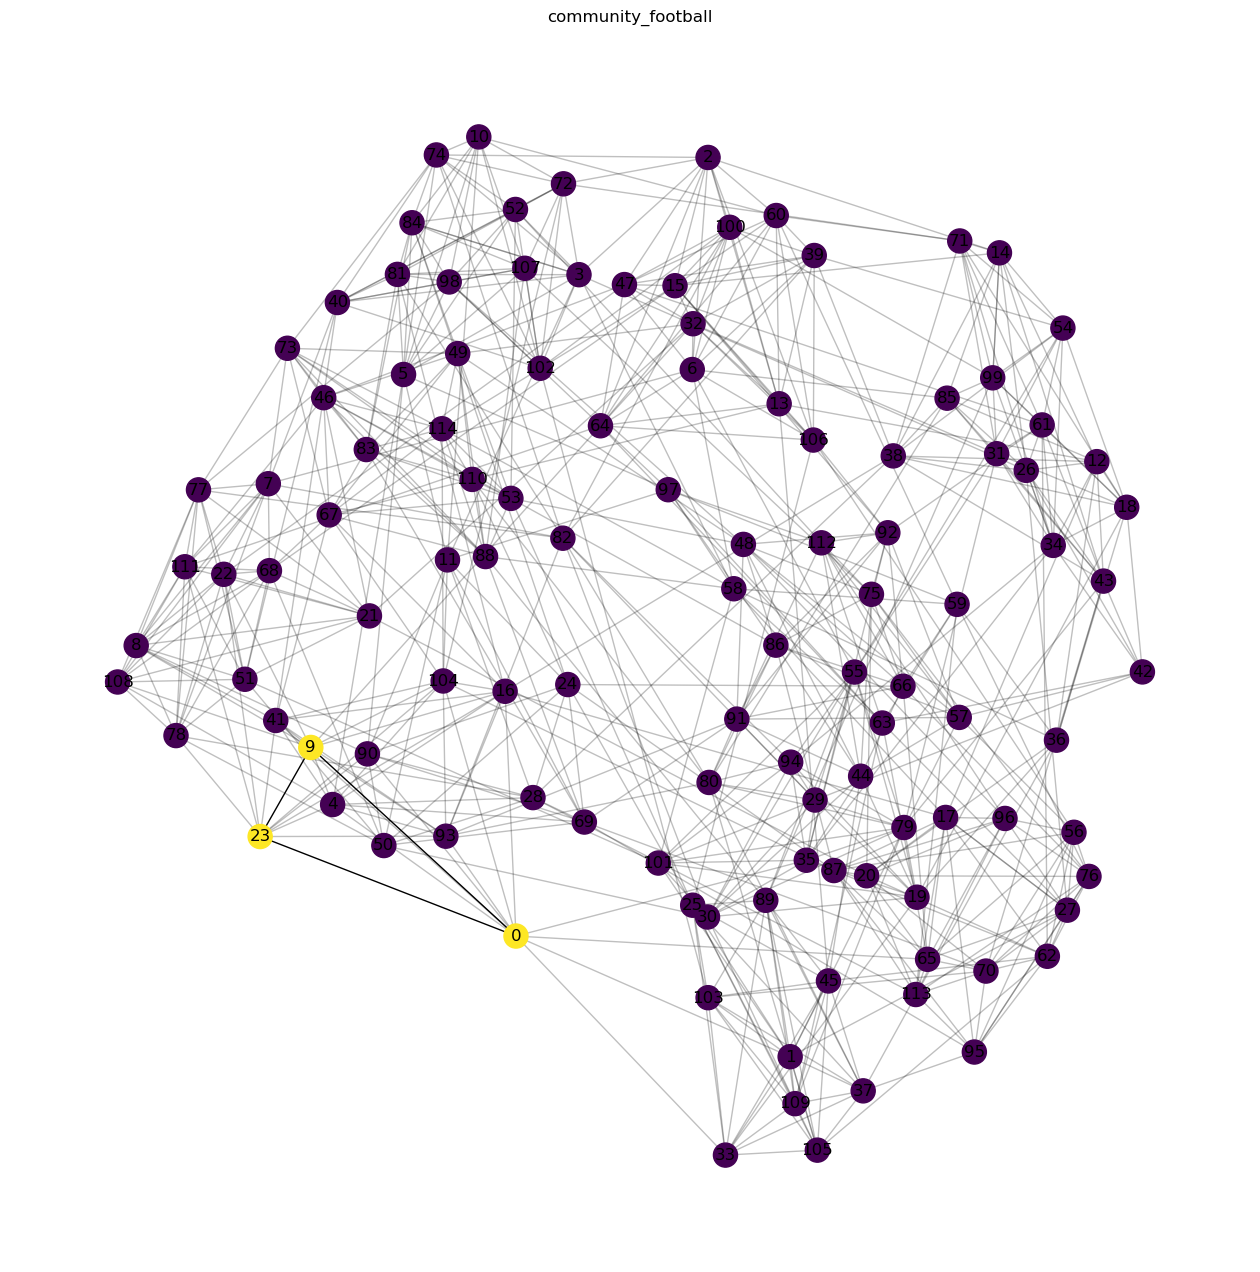

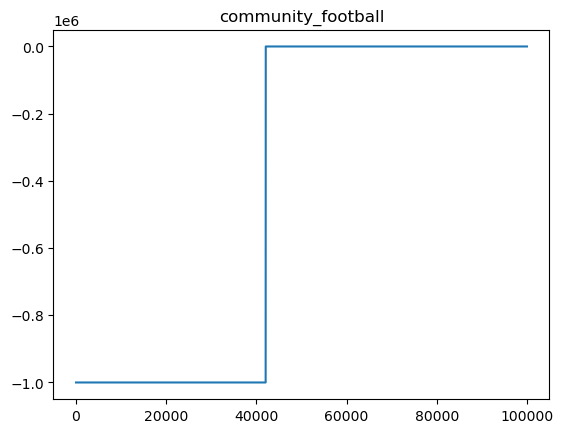

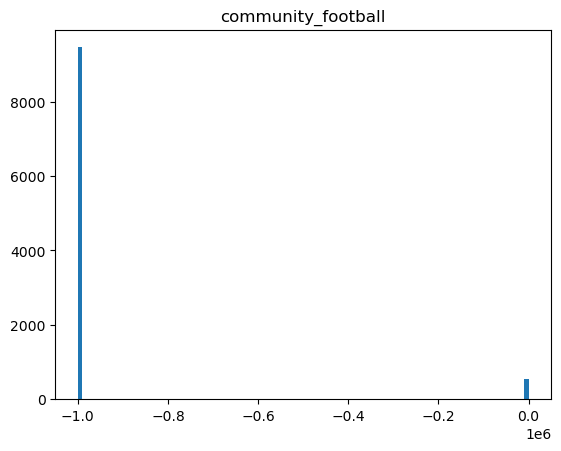

In [127]:
solve(
    "community_football",
    SolverParameters(
        fitness_function=FitnessFunction.DontVisitAll,
        population_len=10_000,
        generations_count=100_000,
        mutation_chance=0.20,
    ),
    show_graph=True,
    weird_graph=True,
)

[42 47  0 14 26 40 20 34 13 55 60  3 39 38 23 41 51 48 32 54 33 36 35  9
 46  5 57 24 30 18 59 10 56 11 37 19  2  6 29 52  1 15 17 25  8 16 45 50
 27 22 49 28  7 53 61 58 44 21 43 31 12  4]
extra_answer_count =  9999


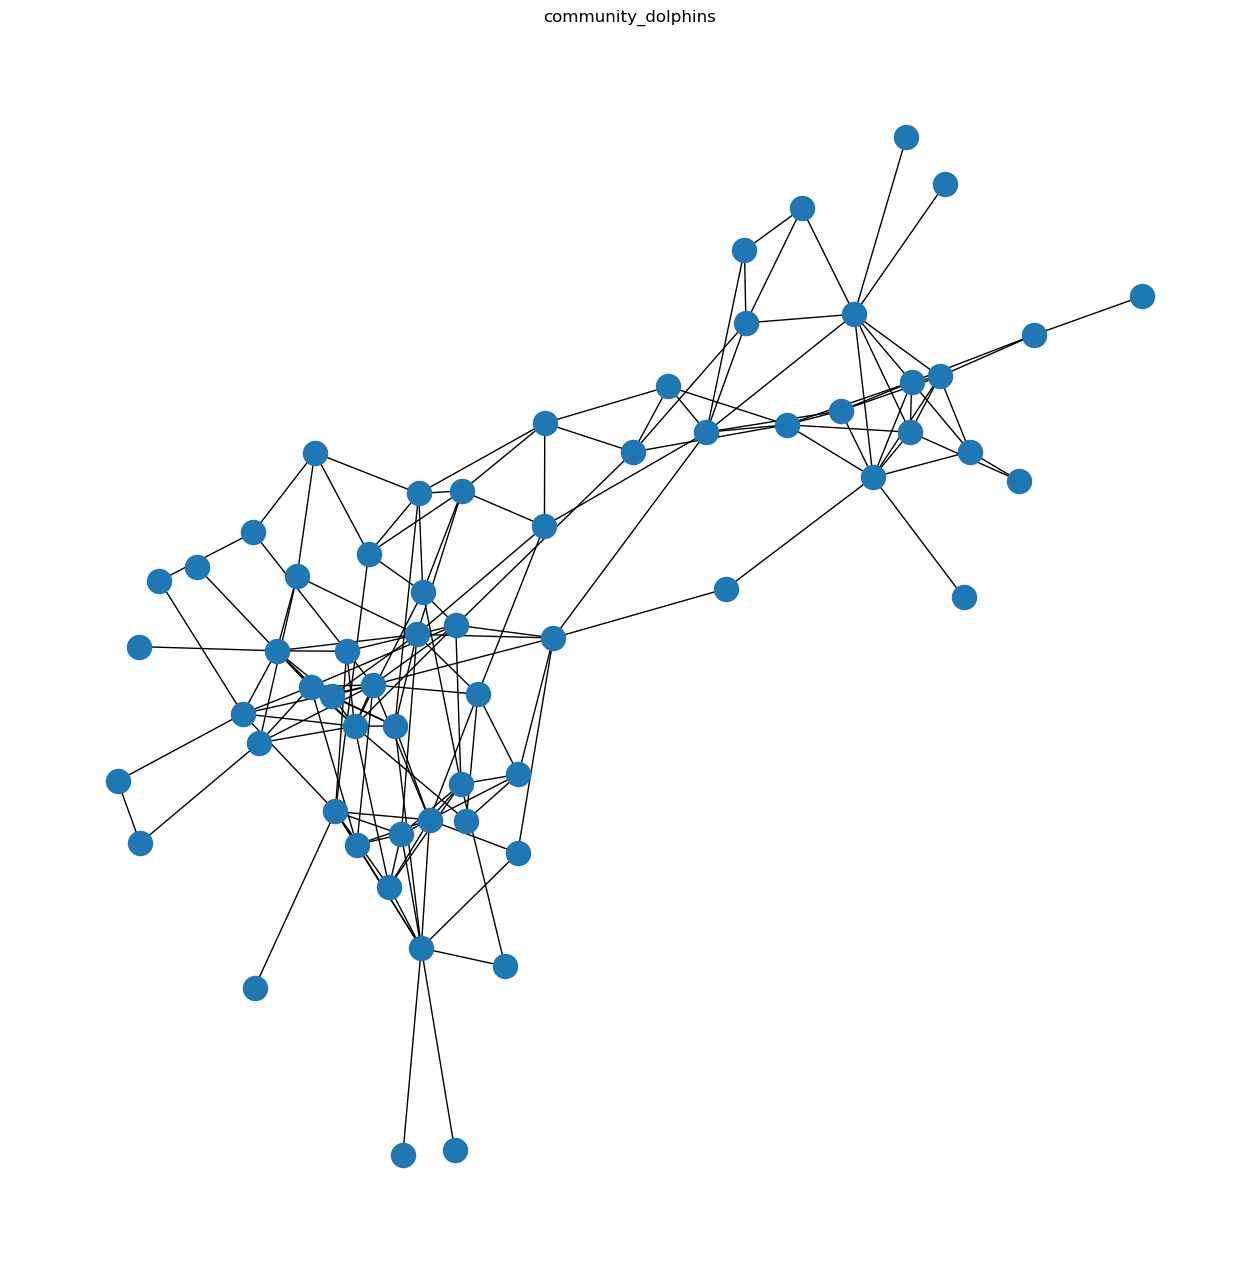

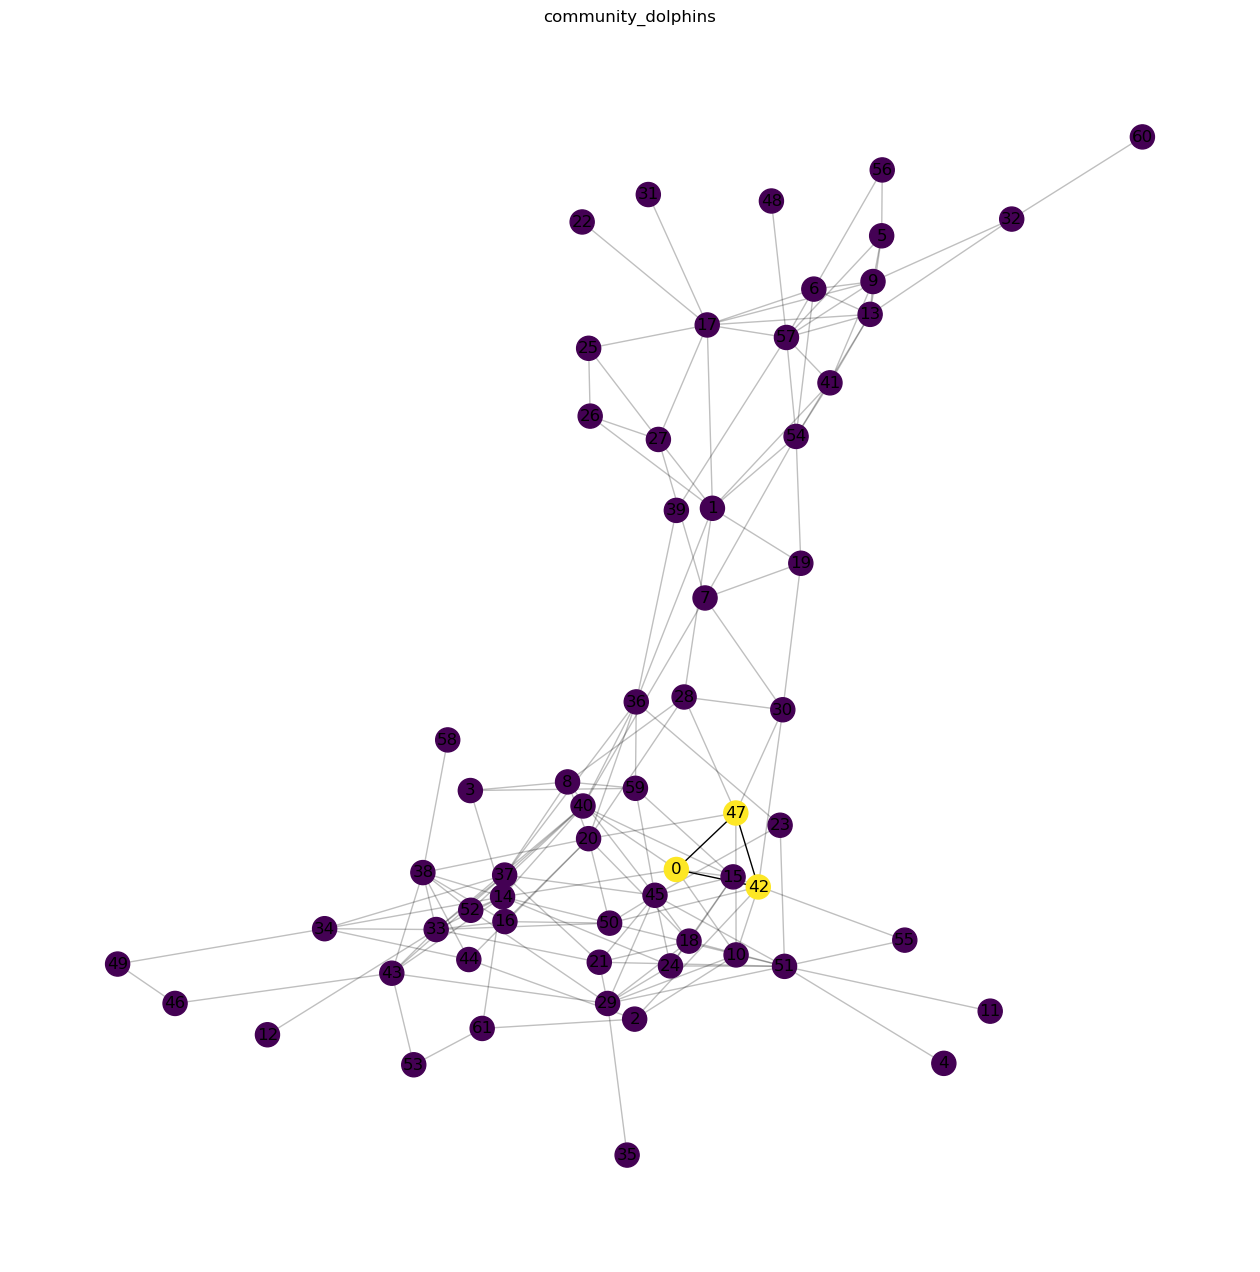

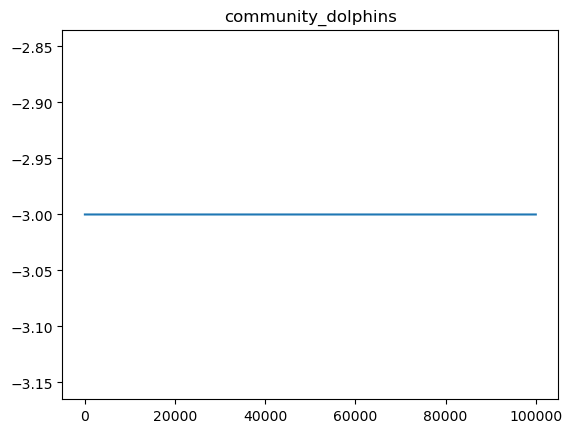

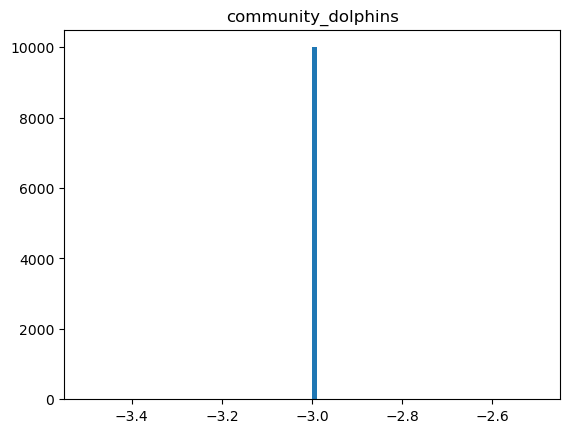

In [128]:
solve(
    "community_dolphins",
    SolverParameters(
        fitness_function=FitnessFunction.DontVisitAll,
        population_len=10_000,
        generations_count=100_000,
        mutation_chance=0.20,
    ),
    show_graph=True,
    weird_graph=True,
)

In [130]:
solve(
    "ungraph",
    SolverParameters(
        fitness_function=FitnessFunction.DontVisitAll,
        population_len=100,
        generations_count=10_000,
        mutation_chance=0.20,
    ),
    # show_graph=True,
    weird_graph=True,
)

KeyboardInterrupt: 